<a href="https://colab.research.google.com/github/BryanPutnam/MortgageCalculator/blob/master/BryanPutnam_Connect4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Search: Playing Connect 4

Student Name: Bryan Putnam

I have used the following AI tools: ChatGPT (instances will be labled)

I understand that my submission needs to be my own work: BP

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

**Define the components of the search problem:**

* Initial state
  * **Empty board/columns**
* Actions
  * **Each column the player can drop a disc into**
* Transition model (result function)
  * **The current state of the board + an action a player took (dropping a disk);State of the board after player took a turn**
* Goal state (terminal state and utility)
  * **The board state where there is a row (horizontal, vertical, or diagonal) connected of the same color (player has connected 4 of their discs and won)**

How big is the state space? Give an estimate and explain it.

**The board has 6 rows and 7 columns. Each position on the board can have three states (empty, player 1, player 2). The state space could then be 3^(6 * 7) which would give all the possible combinations of how the discs in the board could be arranged. However, because of the rules of the game and gravity, the state space would be smaller than 3^(6 * 7) as there would be invalid arrangements of the discs.**

How big is the game tree that minimax search will go through? Give an estimate and explain it.

**The game tree would have a branching factor (b) of 7 since there are 7 possible columns a player can make their move in. The depth of the game tree is specified in the program (d). The size of the game tree is just how many nodes are in the tree.**

**For a depth of 5:**

**(b^(d + 1) - 1) / (b - 1) => (7^(5 + 1) - 1) / (7 - 1)**

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [ ]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

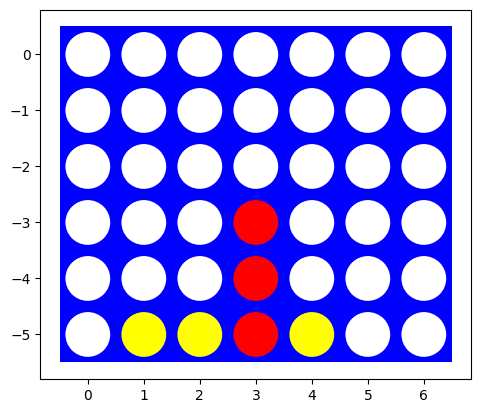

In [ ]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

# changed to numpy array for testing
board = np.array([
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0],
        ])
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [ ]:
def actions(board):
  # columns represented as 0-6
  actions = []

  for col_i, column in enumerate(board.T): # iterate through columns; This line was influenced by ChatGPT
    if 0 in column: # if there is a 0 that means there's an empty spot
      actions.append(col_i) # add column as an available action
  return actions

def result(board, player, action): # where action is the column player drops disc in
  temp_board = np.copy(board)
  for row_i in range(len(temp_board)-1, -1, -1): # iterate backwards/bottom to top of board; # This line was influenced by ChatGPT
    row = temp_board[row_i]
    if row[action] == 0: # find first empty spot
      temp_board[row_i][action] = player # add disc
      break
  return temp_board

# returns 0 if not in terminal state, returns player (1 or -1) if it is
def terminal(board):
  # check rows
  for row in board:
    winner = connects_4(row)
    if winner != 0:
      return winner

  # check columns
  for col in board.T:
    winner = connects_4(col)
    if winner != 0:
      return winner

  # check diagonal
  for diagonal in [board.diagonal(i) for i in range(-2, 4)]: # This line was influenced by ChatGPT
    winner = connects_4(diagonal)
    if winner != 0:
      return winner

  # check diagonal the other way
  for rev_diagonal in [np.fliplr(board).diagonal(i) for i in range(-2, 4)]: # This line was influenced by ChatGPT | np.fliplr(board) just flips the board along the y-axis | https://numpy.org/doc/stable/reference/generated/numpy.fliplr.html
    winner = connects_4(rev_diagonal)
    if winner != 0:
      return winner

  return None # not in terminal state

# returns player if there is a connect 4, 0 if there's none
def connects_4(line):
  for i in range(len(line) - 3): # last 3 spots aren't valid starting points because length is shorter than 4
    subsection = line[i:i+4] # take 4 spots starting from i
    if np.all(subsection == 1):
      return 1
    elif np.all(subsection == -1): #if all 4 spots are the same player
      return -1
  return 0

def utility(board):
  result = terminal(board)
  if result != None: # there is a winner
    return result
  elif np.all(board != 0):
    return 0 # game over no winner
  return None # continue

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [ ]:
def random_player(board, player = 1):
  return np.random.choice(actions(board))

random_player(board)

2

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

**How often does each player win? Is the result expected?**

In [ ]:
def switch_player(player):
  return player * -1

def play():
  scores = {-1: 0, # player 1
             1: 0, # player 2
             0: 0} # draw

  for i in range(1000): # play 1000 times
    board = empty_board()
    player, player_fun = -1, random_player # player, function

    while True:
      action = player_fun(board, player) # get player's move
      board = result(board, player, action) # set new board state
      game_result = utility(board) # check board for win or draw
      if game_result != None: # if the game is over
        scores[game_result] += 1
        break
      player = switch_player(player)

  return scores

In [ ]:
play()

{-1: 555, 1: 444, 0: 1}

**Each player wins close to 50% of the time, meaning there's no bias towards one player. This result is expected as both players are choosing their actions at random with an equal probability of losing or winning the game.**

**The more games played, I would expect the results to keep trending closer to an equal 50/50 probability**

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 1): # Set to player 1
    # Start the search
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab(board, player, -math.inf, +math.inf)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    # Players best move
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: # v = None game is still going
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

def min_value_ab(state, player, alpha, beta):
    # Opponents best response
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, switch_player(player), a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [ ]:
import numpy as np

board_0 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1, -1, -1, 0],
         [1, 1, 1, 0]
        ])

board_1 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

board_2 = np.array([
         [0, 0, 0, 0],
         [0, 0,-1, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

board_3 = np.array([
         [0, 0, 1,-1],
         [0, 0,-1, 1],
         [0, 0,-1, 1],
         [1,-1,-1, 1],
        ])

board_4 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1,-1,-1, 1],
        ])

def play_game():
  boards = [board_0, board_1, board_2, board_3, board_4]
  for i in range(5):
    print("Board " + str(i+1))
    print(alpha_beta_search(boards[i]))
    visualize(boards[i])

Board 1
Number of nodes searched: 2670
{'move': 3, 'value': 1}


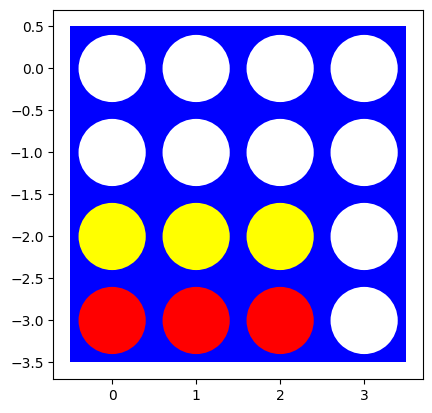

Board 2
Number of nodes searched: 6464
{'move': 3, 'value': 1}


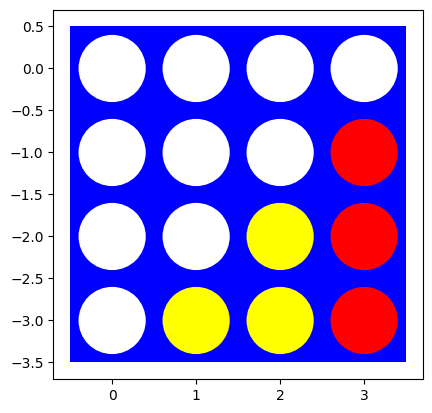

Board 3
Number of nodes searched: 1624
{'move': 3, 'value': 1}


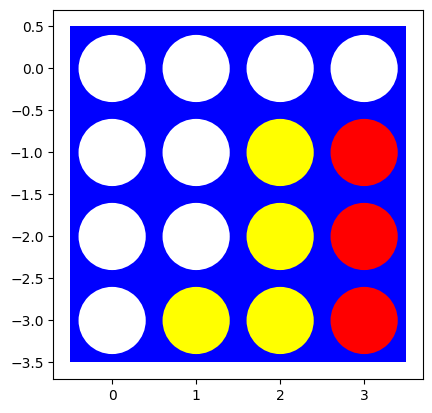

Board 4
Number of nodes searched: 30
{'move': 0, 'value': 0}


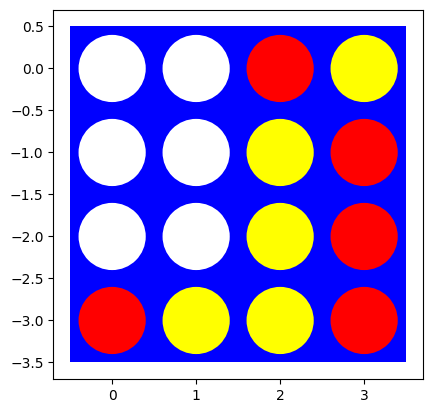

Board 5
Number of nodes searched: 7982
{'move': 0, 'value': 0}


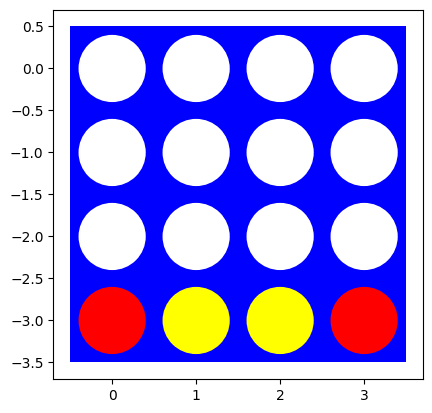

In [ ]:
play_game()

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
import numpy as np

small_board = np.array([
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
        ])

def add_column(init_arr):
  new_column = np.array([
      [0],
      [0],
      [0],
      [0],
  ])
  return np.append(init_arr, new_column, axis=1) # Geeks for Geeks influenced

  visualize(new_arr)

In [ ]:
add_column(small_board)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
import time

b = np.array([
         [0, 0, 0, 0],
         [0, 0,-1, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

for i in range(4):
  start_time = time.time()
  move = alpha_beta_search(b)
  end_time = time.time()
  print("Number of columns: ", len(b[0]))
  print("Time to make move: ", end_time - start_time)
  print(move)
  print("--------------------")

  b = add_column(b)


Number of nodes searched: 1624
Number of columns:  4
Time to make move:  0.4572896957397461
{'move': 3, 'value': 1}
--------------------
Number of nodes searched: 10624
Number of columns:  5
Time to make move:  3.3176321983337402
{'move': 3, 'value': 1}
--------------------
Number of nodes searched: 640973
Number of columns:  6
Time to make move:  242.57122468948364
{'move': 2, 'value': 1}
--------------------


KeyboardInterrupt: ignored

This took an unreasonably long time to run so I interrupted the runtime. There are no errors in the code

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# sorts moves by how many consecutive discs (vertically) there would be if that move was made
def move_ordering(board, actions, player):
  sorted_moves = sorted(actions, key=lambda a: move_heuristic(board, a, player), reverse=True) # This line was influenced by ChatGPT
  return sorted_moves

def move_heuristic(board, column, player):
  temp = board.copy()
  open_row = np.argmax(temp[:, column] == 0) # finds first opening for disc; # This line was influenced by ChatGPT
  temp[open_row][column] = player
  return count_discs(temp[:, column], player)

def count_discs(line, player):
  cnt = 0
  num_consecutive = 0
  for spot in line:
    if spot == player:
      cnt += 1
      num_consecutive = max(num_consecutive, cnt)
    else:
      cnt = 0 # restart count
  return num_consecutive

In [ ]:
# copied code from cell above but inserted move ordering strat

import math

# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search_mo(board, player = 1): # Set to player 1
    # Start the search
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab_mo(board, player, -math.inf, +math.inf)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return { "move": move, "value": value }

def max_value_ab_mo(state, player, alpha, beta):
    # Players best move
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: # v = None game is still going
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in move_ordering(board, actions(state), player): # USE MOVE ORDERING STRATEGY
        v2, a2 = min_value_ab_mo(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

def min_value_ab_mo(state, player, alpha, beta):
    # Opponents best response
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in move_ordering(board, actions(state), player): # USE MOVE ORDERING STRATEGY
        v2, a2 = max_value_ab_mo(result(state, switch_player(player), a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

In [ ]:
import time

b = np.array([
         [0, 0, 0, 0],
         [0, 0,-1, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

for i in range(4):
  start_time = time.time()
  move = alpha_beta_search_mo(b)
  end_time = time.time()
  print("Number of columns: ", len(b[0]))
  print("Time to make move: ", end_time - start_time)
  print(move)
  print("--------------------")
  b = add_column(b)


Number of nodes searched: 184
Number of columns:  4
Time to make move:  0.05760049819946289
{'move': 3, 'value': 1}
--------------------
Number of nodes searched: 2632
Number of columns:  5
Time to make move:  0.7277436256408691
{'move': 3, 'value': 1}
--------------------
Number of nodes searched: 24366
Number of columns:  6
Time to make move:  8.993059873580933
{'move': 3, 'value': 1}
--------------------
Number of nodes searched: 210426
Number of columns:  7
Time to make move:  97.69447922706604
{'move': 3, 'value': 1}
--------------------


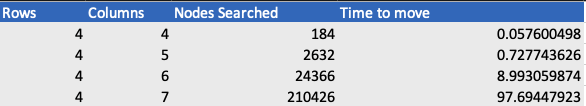



### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

Answer: To make minimax search more efficient when starting from an empty board you can employ the use of heuristics (such as move_ordering above) to choose the best actions based on how effective the outcome would be. You can also use a depth search with a limit on how far the search should go and backtrack if the limit is reached before finding a terminal state.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
class MinimaxAgent:
  def __init__(self, init_move = -1):
    self.last_move = init_move

  def make_move(self, board, player = 1):
    move = alpha_beta_search_mo(board, player) # heuristic ordering
    self.last_move = move['move']
    return self.last_move


In [ ]:
agent = MinimaxAgent()
player_actions = [agent.make_move, random_player]

def switch_player_2(player):
  next_player = (player + 1) % 2 # swap players
  return next_player

def play():
  scores = {-1: 0, # player 1
             1: 0, # player 2
             0: 0} # draw

  for i in range(10):
    board = empty_board((4,4))
    player_action_i = 0
    while True:
      current_player = -1 if player_action_i == 0 else 1 # gets who's player 1 or -1
      player_function = player_actions[player_action_i]

      player_move = player_function(board, current_player) # get player's move
      board = result(board, current_player, player_move) # set new board state
      game_result = utility(board) # check board for win or draw
      if game_result != None: # if the game is over
        scores[game_result] += 1
        print("Game result: ", game_result)
        break
      player_action_i = switch_player_2(player_action_i)

  return scores

In [ ]:
play()

Game result:  -1
Game result:  1
Game result:  -1
Game result:  -1
Game result:  1
Game result:  -1
Game result:  0
Game result:  0
Game result:  -1
Game result:  -1


{-1: 6, 1: 2, 0: 2}

Explination: Even with only 10 games (limited number of games due to lengthy runtime) there's heavy bias towards the minimax agent. This is expected because the minimax agent employs the use of move ordering and heuristic evaluation to determine the most efficient move from all the possibilities to choose from, whereas the random player is just choosing at random with no real strategy or plan.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [ ]:
# already implemented heuristic evaluation function for move ordering. Pasting here:

# sorts moves by how many consecutive discs (vertically) there would be if that move was made
def move_ordering(board, actions, player):
  sorted_moves = sorted(actions, key=lambda a: move_heuristic(board, a, player), reverse=True) # This line was influenced by ChatGPT
  return sorted_moves

# heuristic evaluation function
def move_heuristic(board, column, player):
  temp = board.copy()
  open_row = np.argmax(temp[:, column] == 0) # finds first opening for disc; # This line was influenced by ChatGPT
  temp[open_row][column] = player
  return count_discs(temp[:, column], player)

def count_discs(line, player):
  cnt = 0
  num_consecutive = 0
  for spot in line:
    if spot == player:
      cnt += 1
      num_consecutive = max(num_consecutive, cnt)
    else:
      cnt = 0 # restart count
  return num_consecutive

Explination: I already implemented a hueristic function for move ordering, so I figured I'd use it again here. This heurisitc function takes all of the available actions a player can take, and sorts them in order of desirability (utility). In this case, desirability is defined by how many consecutive discs of the same color, placed horizontally, would result from the player dropping their disc in that column (obviously only up to 4 which would result in a win).

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# copied code from cell above but inserted move ordering strat

import math

# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search_cutoff(board, player = 1, depth=1000): # Set to player 1
    # Start the search
    global DEBUG, COUNT
    COUNT = 0

    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, depth)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    return { "move": move, "value": value }

def max_value_ab_cutoff(state, player, alpha, beta, depth=1000):
    # Players best move
    global DEBUG, COUNT
    COUNT += 1

    if COUNT >= depth: # depth limit reach
        if DEBUG >= 2: print(f"depth limit reached. backtracking.")
        return 0, None

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: # v = None game is still going
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in move_ordering(board, actions(state), player): # USE MOVE ORDERING STRATEGY
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth=1000):
    # Opponents best response
    global DEBUG, COUNT
    COUNT += 1

    if COUNT >= depth: # depth limit reach
        if DEBUG >= 2: print(f"depth limit reached. backtracking.")
        return 0, None

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"found terminal state. backtracking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in move_ordering(board, actions(state), player): # USE MOVE ORDERING STRATEGY
        v2, a2 = max_value_ab_cutoff(result(state, switch_player(player), a), player, alpha, beta, depth)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

In [ ]:
depths = [5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

b = np.array([
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0,-1,-1,-1],
         [0,-1,-1, 1],
        ])

class MinimaxAgentCutoff:
  def __init__(self, init_move = -1):
    self.last_move = init_move

  def make_move(self, board, player = 1, depth = 1000):
    move = alpha_beta_search_cutoff(board, player, depth) # heuristic ordering
    self.last_move = move['move']
    return self.last_move

def test_cutoffs():
  agent = MinimaxAgentCutoff()
  for d in depths:
    start_time = time.time()
    move = agent.make_move(b, 1, d)
    end_time = time.time()
    print("Depth limit: ", d)
    print("Time to make move: ", end_time - start_time)
    print(move)
    print("--------------------")


In [ ]:
test_cutoffs()

Depth limit:  5
Time to make move:  0.0024449825286865234
3
--------------------
Depth limit:  10
Time to make move:  0.0034377574920654297
3
--------------------
Depth limit:  50
Time to make move:  0.017134904861450195
3
--------------------
Depth limit:  100
Time to make move:  0.02135634422302246
3
--------------------
Depth limit:  500
Time to make move:  0.0931553840637207
3
--------------------
Depth limit:  1000
Time to make move:  0.11115574836730957
2
--------------------
Depth limit:  5000
Time to make move:  0.12341737747192383
2
--------------------
Depth limit:  10000
Time to make move:  0.13932251930236816
2
--------------------
Depth limit:  50000
Time to make move:  0.114288330078125
2
--------------------
Depth limit:  100000
Time to make move:  0.131486177444458
2
--------------------


Explination: The deeper the program is allowed to search, the longer it takes however it will produce more effective and strategic moves.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
board_0 = np.array([
         [ 0, 0, 0, 1],
         [ 0, 0, 0,-1],
         [-1,-1,-1, 1],
         [ 1, 1, 1,-1]
        ])

board_1 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

board_2 = np.array([
         [0, 0, 0, 0],
         [1, 0,-1, 0],
         [1, 0,-1, 0],
         [1,-1,-1, 0],
        ])

board_3 = np.array([
         [0, 0, -1,0],
         [0, 0,-1, 0],
         [0, 1,1, 1],
         [1,-1,-1, 1],
        ])

board_4 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1,-1,-1, 1],
        ])

def play3():
  agent = MinimaxAgentCutoff()
  boards = [board_0, board_1, board_2, board_3, board_4]
  for i in range(5):
    print("Board " + str(i+1))
    print("Move: ", agent.make_move(boards[i], 1, 1000))
    visualize(boards[i])
    print("-----------------------------------------")

Board 1
Move:  0


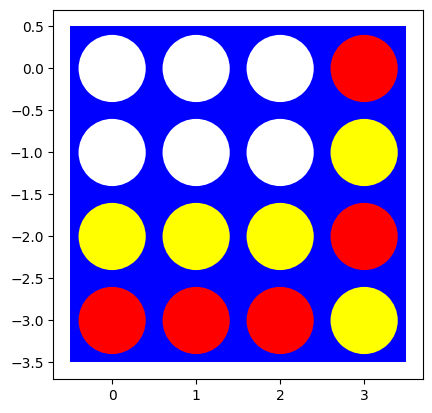

-----------------------------------------
Board 2
Move:  3


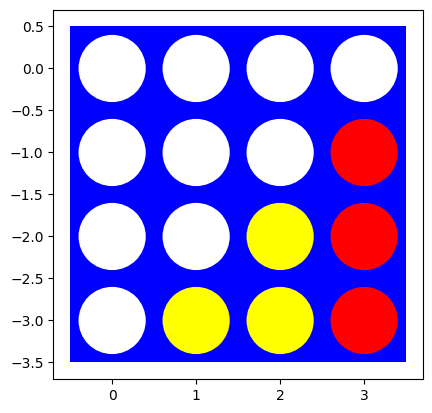

-----------------------------------------
Board 3
Move:  0


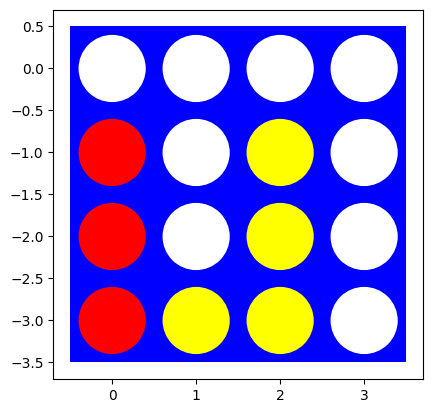

-----------------------------------------
Board 4
Move:  3


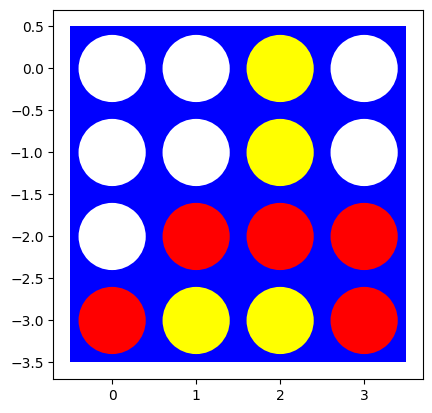

-----------------------------------------
Board 5
Move:  3


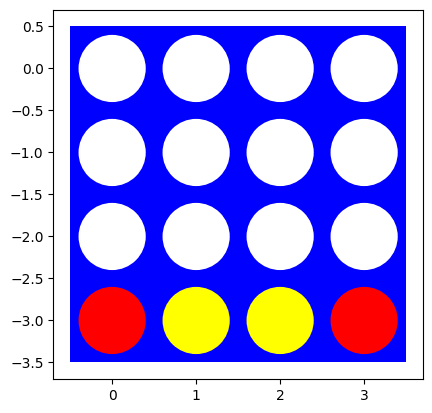

-----------------------------------------


In [ ]:
play3()

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
import time

b = np.array([
         [0, 0, 0, 0],
         [0, 0,-1, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

for i in range(4):
  agent = MinimaxAgentCutoff()
  start_time = time.time()
  move = agent.make_move(b, 1, 1000)
  end_time = time.time()
  print("Number of columns: ", len(b[0]))
  print("Time to make move: ", end_time - start_time)
  print(move)
  print("--------------------")
  b = add_column(b)

Number of columns:  4
Time to make move:  0.21390271186828613
3
--------------------
Number of columns:  5
Time to make move:  1.0439093112945557
3
--------------------
Number of columns:  6
Time to make move:  1.04130220413208
3
--------------------
Number of columns:  7
Time to make move:  0.7116353511810303
3
--------------------


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
agents = [MinimaxAgentCutoff(), MinimaxAgentCutoff()]
depths = [1000, 5000]

def switch_agent(agent_i):
  next_agent = (agent_i + 1) % 2
  return next_agent

def play4():
  board = empty_board()
  agent_i = 0
  while True:
    current_agent = -1 if agent_i == 0 else 1 # gets who's player 1 or -1
    agent_action = agents[agent_i].make_move(board, current_agent, depths[agent_i]) # get player's move
    board = result(board, current_agent, agent_action) # set new board state
    game_result = utility(board) # check board for win or draw
    if game_result != None: # if the game is over
      print("Winner: ", current_agent)
      break
    agent_i = switch_agent(agent_i)

In [ ]:
play4()

Winner:  1


Explination: Minimax with the larger depth won (expected result)

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
board_0 = np.array([
         [ 0, 0, 0, 1],
         [ 0, 0, 0,-1],
         [-1,-1,-1, 1],
         [ 1, 1, 1,-1]
        ])

board_1 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0,-1, 1],
         [0,-1,-1, 1],
        ])

board_2 = np.array([
         [0, 0, 0, 0],
         [1, 0,-1, 0],
         [1, 0,-1, 0],
         [1,-1,-1, 0],
        ])

board_3 = np.array([
         [0, 0, -1,0],
         [0, 0,-1, 0],
         [0, 1,1, 1],
         [1,-1,-1, 1],
        ])

board_4 = np.array([
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1,-1,-1, 1],
        ])

def PureMonteCarlo(board, player = 1, simulations=1000):
  temp_board = board.copy()
  possible_moves = actions(temp_board)
  scores = {m: 0 for m in possible_moves} # keep track of the scores for each move
  for _ in range(simulations):
    for m in possible_moves: # for every move
      scores[m] += simulate(temp_board, player, m) # simulate a whole game and store whether player won & how many times with that move
  print(scores)
  choice_move = max(possible_moves, key=lambda move: scores[move]) # influenced by ChatGPT
  return choice_move


def simulate(board, player, initial_move):
  # make the initial move and check the result
  board = result(board, player, initial_move)
  game_result = utility(board)
  while game_result == None: # while game is still on
    # make another move as other player and check board
    next_move = np.random.choice(actions(board))
    player = switch_player(player)
    board = result(board, player, next_move)
    game_result = utility(board)

  if game_result == player:
    return 1 # add point
  elif game_result == switch_player(player):
    return -1 # deduct point for lose
  return 0

In [ ]:
def play5():
  boards = [board_0, board_1, board_2, board_3, board_4]
  for i in range(5):
    print("Board " + str(i+1))
    print("Move: ", PureMonteCarlo(boards[i]))
    visualize(boards[i])
    print("-----------------------------------------")

Board 1
{0: 272, 1: 0, 2: 333}
Move:  2


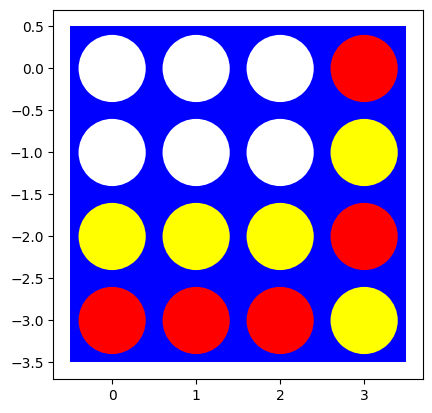

-----------------------------------------
Board 2
{0: 631, 1: 640, 2: 677, 3: 1000}
Move:  3


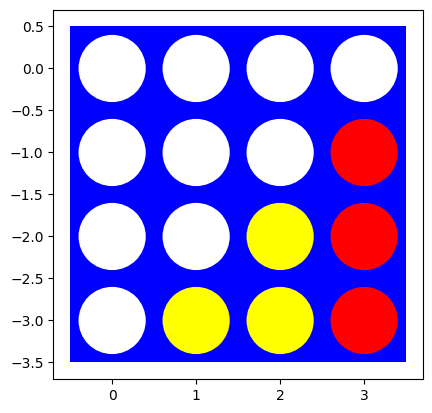

-----------------------------------------
Board 3
{0: 1000, 1: 804, 2: 551, 3: 708}
Move:  0


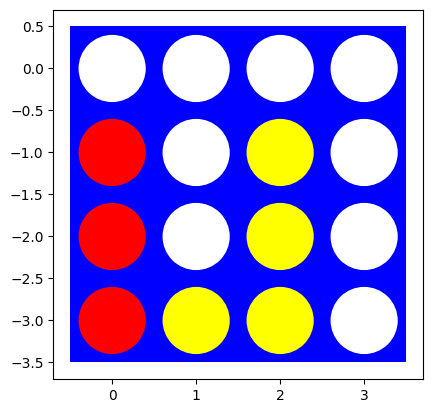

-----------------------------------------
Board 4
{0: 1000, 1: 901, 3: 906}
Move:  0


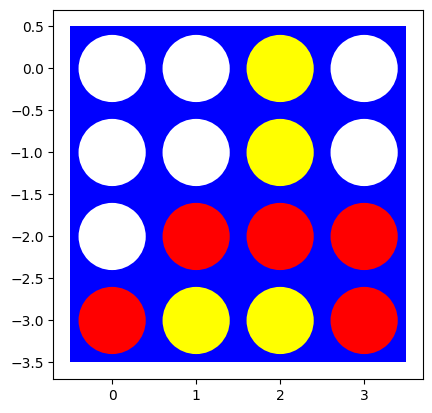

-----------------------------------------
Board 5
{0: 535, 1: 506, 2: 491, 3: 527}
Move:  0


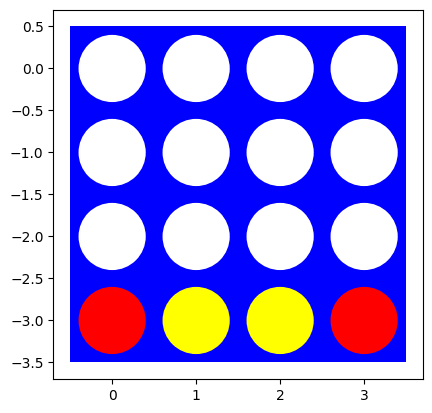

-----------------------------------------


In [ ]:
play5()

### Best First Move

Use Pure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

Using Pure Monte Carlo search, we can figure out what the best first move is by analysing the sucess of the simulated moves. Just like the Alpha Beta tree search where searching deeper yeilds better results, the same is true for Pure Monte Carlo Search. The more simulations you run, the more "accurate" your data will be and the more informed your move will be.

The assumption of the true best first move is ssubjective the the data you gather in your simulations. Through my simulations, I was able to reletivley determing the best first move by analysis the number of games that could be won by doing that first move. The move with the highest number can be assumed to be the best first move. However, this may not always be the case as the Pure Monte Carlo Search does rely on some randomness. Therefore, there may always be a better solution that is just not immedietly (or realistically) found.